## Python import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

from keras import layers
from keras import models
from keras import Input
from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras import regularizers # L2규제

from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.callbacks import LearningRateScheduler # callbacks 설정

from tqdm.notebook import tqdm # 모델학습 진행 시간 파악
import random # random seed를 뽑을때 사용

## Load Data

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## EDA

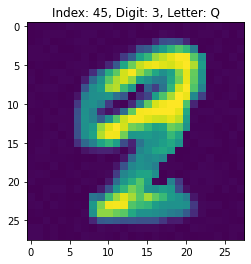

In [3]:
idx = 45
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

## Train model

In [4]:
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train/255

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1

In [5]:
def create_cnn_model():
    inputs = Input(shape = (28,28,1))

    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    bn = tf.keras.layers.BatchNormalization()(pool)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [50]:
create_cnn_model().summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 28, 28, 128)       3328      
_________________________________________________________________
batch_normalization_43 (Batc (None, 28, 28, 128)       512       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 128)       65664     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 14, 14, 128)       512 

In [8]:
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
model.add(layers.Conv2D(32, kernel_size = 3, activation='relu'))
model.add(layers.Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(layers.Dropout(0.35))

model.add(layers.Conv2D(64, kernel_size = 3, activation='relu'))
model.add(layers.Conv2D(64, kernel_size = 3, activation='relu'))
model.add(layers.Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(layers.Dropout(0.35))

model.add(layers.Conv2D(128, kernel_size = 4, activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.35))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 12, 12, 32)        25632     
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 4, 4, 64)         

In [9]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

#model = create_cnn_model()
epochs=100

#model.fit(x_train, y_train, epochs=50)

history = model.fit(
  datagen.flow(x_train, y_train, batch_size=32),
  epochs=epochs, 
  steps_per_epoch = x_train.shape[0]//32,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/100
64/64 [==============================] - 4s 59ms/step - loss: 2.2933 - accuracy: 0.1187 - lr: 0.0010
Epoch 2/100
64/64 [==============================] - 4s 55ms/step - loss: 2.1315 - accuracy: 0.2153 - lr: 9.5000e-04
Epoch 3/100
64/64 [==============================] - 3s 55ms/step - loss: 1.9644 - accuracy: 0.2935 - lr: 9.0250e-04
Epoch 4/100
64/64 [==============================] - 4s 58ms/step - loss: 1.7506 - accuracy: 0.3794 - lr: 8.5737e-04
Epoch 5/100
64/64 [==============================] - 4s 56ms/step - loss: 1.6574 - accuracy: 0.4136 - lr: 8.1451e-04
Epoch 6/100
64/64 [==============================] - 4s 56ms/step - loss: 1.5502 - accuracy: 0.4678 - lr: 7.7378e-04
Epoch 7/100
64/64 [==============================] - 4s 57ms/step - loss: 1.4573 - accuracy: 0.4941 - lr: 7.3509e-04
Epoch 8/100
64/64 [==============================] - 3s 52ms/step - loss: 1.3677 - accuracy: 0.5356 - lr: 6.9834e-04
Epoch 9/100
64/64 [==============================] - 3s 53ms/step - 

## Predict

In [10]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = x_test/255

submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x_test), axis=1)
submission.head()

,id,digit
0,2049,6
1,2050,8
2,2051,8
3,2052,0
4,2053,3


In [11]:
submission.to_csv('epoch100_Layer 축소.csv', index=False)